# Notebook Details
### For full transparency, this notebook provides the code to generate the data already provided in this folder.
Note: notebook has different dependencies than GFN-ROM.

## Data for GCA-ROM
- On a fine mesh (`large`), generate a dataset of high-fidelity solutions using the finite element method, returning
    - `matrix_large.mat` (high-fidelity solution data)
    
## Data for POD-based approaches
- From the high-fidelity solution, generate reduced order model (Galerkin-POD) solutions, returning
    - `reduced_matrix.npy` (Galerkin-POD approximation of high-fidelity solution)
    - `basis_matrix.npy` (basis matrix found via POD)
- Generate a projection of the high-fidelity solution onto the reduced space, returning
    - `projected_matrix.npy` (reduced coefficients from projection of high-fidelity solution onto reduced space)
    - `reduced_proj_matrix.npy` (approximation of high-fidelity solution from `projected_matrix.npy`)
    
## Data for GFN-ROM
- Generate a hierarchy of high-fidelity solutions on 4 different discretisations using the moving front subsampling algorithm
    - for `{name} = large, medium, small, tiny`
        - `snapshot_matrix_{name}.npy` (high-fidelity solution on progressively coarser meshes)
        - `reference_mesh_{name}.npy` (mesh on which solution is computed)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm
import h5py
import xml.etree.ElementTree as ET
# rbnics-related imports (for finite element modelling and reduced order modelling)
from dolfin import *
from rbnics import *
from rbnics.backends import export, transpose
from rbnics.backends.online import OnlineFunction, OnlineVector
from rbnics.sampling.distributions.distribution import Distribution
from rbnics.utils.io import OnlineSizeDict
# gfn_rom related imports (parameter defaults and PDE details)
import sys
sys.path.append("../..")
from gfn_rom import pde, defaults, preprocessing

## Problem Set-Up

In [2]:
pname = 'graetz'

In [3]:
params = pde.params(pname)
np.random.seed(defaults.split_seed)
train_trajs, test_trajs = preprocessing.train_test_split(params, 1, defaults.rate)
train_trajs = train_trajs[0]

In [4]:
# generate a fine discretisation of the domain
!python mesh_gen.py

Mesh generated
Num vertices: 7205
Num elements: 14024
Max mesh element size: 0.026831357545718297
Min mesh element size: 0.013893367813168281


In [5]:
# Define the problem

# @SCM()
# @ExactStabilityFactor()
@PullBackFormsToReferenceDomain()
@ShapeParametrization(
    ("x[0]", "x[1]"),  # subdomain 1
    ("mu[0]*(x[0] - 1) + 1", "x[1]"),  # subdomain 2
)
class Graetz(EllipticCoerciveProblem):

    # Default initialization of members
    @generate_function_space_for_stability_factor
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.ds = Measure("ds")(subdomain_data=boundaries)
        # Store the velocity expression
        self.vel = Expression("x[1]*(1-x[1])", element=self.V.ufl_element())
        # Customize eigen solver parameters
        # self._eigen_solver_parameters.update({
        #             "bounding_box_minimum": {"problem_type": "gen_hermitian",
        #                                     "spectral_transform": "shift-and-invert",
        #                                     "spectral_shift": 1.e-5},
        #             "bounding_box_maximum": {"problem_type": "gen_hermitian",
        #                                     "spectral_transform": "shift-and-invert",
        #                                     "spectral_shift": 1.e5},
        #             "stability_factor": {"problem_type": "gen_hermitian",
        #                                 "spectral_transform": "shift-and-invert",
        #                                 "spectral_shift": 1.e-5}
        #         })

    # # Return the alpha_lower bound.
    # def get_stability_factor_lower_bound(self):
    #     # return min(self.compute_theta("a"))
    #     return 1

    # Return custom problem name
    def name(self):
        return "rbnics"

    # Return theta multiplicative terms of the affine expansion of the problem.
    # @compute_theta_for_stability_factor
    def compute_theta(self, term):
        mu = self.mu
        if term == "a":
            theta_a0 = mu[1]
            theta_a1 = 1.0
            return (theta_a0, theta_a1)
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0,)
        elif term == "dirichlet_bc":
            theta_bc0 = 1.0
            return (theta_bc0,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    # @assemble_operator_for_stability_factor
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            vel = self.vel
            a0 = inner(grad(u), grad(v)) * dx
            a1 = vel * u.dx(0) * v * dx
            return (a0, a1)
        elif term == "f":
            f0 = Constant(0.0) * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 3),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 5),
                   DirichletBC(self.V, Constant(1.0), self.boundaries, 6),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 7),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 8)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

In [6]:
# 1. read the mesh for this problem
mesh = Mesh("mesh.xml")
subdomains = MeshFunction("size_t", mesh, "subdomains.xml")
boundaries = MeshFunction("size_t", mesh, "boundaries.xml")

In [7]:
# 2. create finite element space
V = FunctionSpace(mesh, "Lagrange", 1)

In [8]:
# 3. allocate an object of the Graetz class
problem = Graetz(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(1., 3.), (0.01, 0.1)]
problem.set_mu_range(mu_range)

In [9]:
# 4. create a POD-Galerkin reduced method
N_max = int(params.shape[1] * defaults.N_basis_factor) - int(pname=='stokes' or pname=='graetz')
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(N_max)
reduction_method.set_tolerance(defaults.tol)

In [10]:
# 5. initialise training set for POD-Galerkin and run POD-Galerkin training phase
class DatasetSampler(Distribution):
    def __init__(self, training_samples):
        self.training_samples = list(map(tuple, training_samples))
        self.n = len(training_samples)
    def sample(self, _, n):
        assert n==self.n
        return self.training_samples
reduction_method.initialize_training_set(train_trajs.shape[0], sampling=DatasetSampler(params[train_trajs]))
reduced_problem = reduction_method.offline()

Computing and storing lifting function n. 0 (obtained for mu = (1.0, 0.01)) in the basis matrix
=                   rbnics POD-Galerkin offline phase begins                   =

###################################### 0 #######################################
truth solve for mu = (1.0, 0.01473684210526316)
update snapshots matrix

###################################### 1 #######################################
truth solve for mu = (1.0, 0.019473684210526317)
update snapshots matrix

###################################### 2 #######################################
truth solve for mu = (1.0, 0.03368421052631579)
update snapshots matrix

###################################### 3 #######################################
truth solve for mu = (1.0, 0.04315789473684211)
update snapshots matrix

###################################### 4 #######################################
truth solve for mu = (1.0, 0.05736842105263158)
update snapshots matrix

###################################### 5 ##########

update snapshots matrix

###################################### 48 ######################################
truth solve for mu = (2.5555555555555554, 0.1)
update snapshots matrix

###################################### 49 ######################################
truth solve for mu = (2.7777777777777777, 0.019473684210526317)
update snapshots matrix

###################################### 50 ######################################
truth solve for mu = (2.7777777777777777, 0.024210526315789474)
update snapshots matrix

###################################### 51 ######################################
truth solve for mu = (2.7777777777777777, 0.052631578947368425)
update snapshots matrix

###################################### 52 ######################################
truth solve for mu = (2.7777777777777777, 0.0668421052631579)
update snapshots matrix

###################################### 53 ######################################
truth solve for mu = (2.7777777777777777, 0.07631578947368421)


## Compute High-Fidelity and Reduced Order Model Solutions

In [11]:
# create numpy arrays to store data
n_samples = params.shape[0]
projected_matrix = np.zeros((n_samples, N_max+1))
reduced_matrix = np.zeros((n_samples, mesh.num_vertices()))
snapshot_matrix = np.zeros((n_samples, mesh.num_vertices()))
reduced_proj_matrix = np.zeros((n_samples, mesh.num_vertices()))

dofmap = V.dofmap()
dofs = dofmap.dofs(mesh, 0)

for i, values in enumerate(tqdm(params)):
    online_mu = tuple(values)

    # high-fidelity (truth solver)
    problem.set_mu(online_mu)
    # solve and export
    snapshot = problem.solve()
    problem.export_solution(folder='highfid', filename="solution", suffix=i)

    # Galerkin POD solver
    reduced_problem.set_mu(online_mu)
    reduced_solution = reduced_problem.solve()
    # solve and export approximation of the high-fidelity solution for u
    rb_nn = reduced_problem.basis_functions[["u"]] * reduced_solution.vector()
    reduced_matrix[i] = np.array(rb_nn.vector())[dofs]

    # compute projection of high-fidelity solutions for u onto the reduced space
    projected_val = reduced_problem.project(snapshot).vector()
    projected_matrix[i] = np.array(projected_val)
    # compute the approximation of the high-fidelity solutions obtained from these projections
    x_rb_rec = reduced_problem.basis_functions[["u"]] * projected_val
    reduced_proj_matrix[i] = np.array(x_rb_rec.vector())[dofs]

100%|█████████████████████████████████████████████████████████████████████████████████| 200/200 [02:09<00:00,  1.55it/s]


In [12]:
# convert high-fidelity solution from rbnics format to format readable by GCA-ROM
!python h5_to_mat.py

In [13]:
# store high-fidelity solution in a snapshot matrix
f = h5py.File("highfid/solution.h5")
for i in range(n_samples):
    snapshot_matrix[i] = np.array(f["VisualisationVector/"+str(i)])[:, 0]

In [14]:
# store basis functions
# reduced_proj_matrix[i] == basis_matrix @ projected_coeff_matrix[i]
basis_matrix = np.array(list(map(lambda x: np.array(x.vector()), reduced_problem.basis_functions[["u"]])))[:, dofs].T.reshape(mesh.num_vertices(), N_max+1)

In [15]:
# save relevant data to npy files
np.save('snapshot_matrix_large.npy', snapshot_matrix)
np.save('reduced_matrix.npy', reduced_matrix)
np.save('reduced_proj_matrix.npy', reduced_proj_matrix)
np.save('projected_matrix.npy', projected_matrix)
np.save('basis_matrix.npy', basis_matrix)

## Generate Hierarchy of Solutions (Multifidelity Dataset)

In [16]:
# convert reference mesh into numpy format
vertices = ET.parse("mesh.xml").getroot()[0][0]

reference_mesh = np.zeros((mesh.num_vertices(), 2))

for vertex in vertices:
    reference_mesh[int(vertex.attrib['index']), 0] = np.double(vertex.attrib['x'])
    reference_mesh[int(vertex.attrib['index']), 1] = np.double(vertex.attrib['y'])

np.save('reference_mesh_large.npy', reference_mesh)

In [17]:
# Moving front subsampling algorithm from https://arxiv.org/pdf/2303.09080.pdf
# "Node Subsampling for Multilevel Meshfree Elliptic PDE Solvers"
# by A. Lawrence, M. Nielsen and B. Fornberg

def MFNUS(xy, fc=1.5, K=10):
    assert xy.shape[0] >= xy.shape[1]
    orig = xy
    # algorithm
    N = xy.shape[0] # Get the number of its dots
    sort_ind = np.lexsort(xy.T,axis=0)
    xy = xy[sort_ind, :] # Sort dots from bottom and up
    # Create nearest neighbor pointers and distances
    nbrs = NearestNeighbors(n_neighbors=K+1, algorithm='auto').fit(xy)
    distances, indices = nbrs.kneighbors(xy)
    for k in range(N): # Loop over nodes from bottom and up
        if indices[k, 0] != N+1: # Check if node already eliminated
            ind = np.where(distances[k, 1:] < fc * distances[k, 1])[0]
            ind2 = indices[k, ind+1]
            ind2 = np.delete(ind2,ind2 < k) # Mark nodes above present one, and which
            indices[ind2, 0] = N+1 # are within the factor fc of the closest one
    elim_ind_sorted = indices[:, 0] != N+1
    xy_sub = xy[elim_ind_sorted]
    indexes = sort_ind[elim_ind_sorted]
    assert ((xy_sub-orig[indexes])**2).sum()==0
    return indexes

In [18]:
def subsample_and_plot(mesh, sol, name):
    subsample = MFNUS(mesh)
    print(len(subsample))

    subsampled_mesh = mesh[subsample]
    subsampled_solution = sol[:, subsample]

    np.save(f'reference_mesh_{name}.npy', subsampled_mesh)
    np.save(f'snapshot_matrix_{name}.npy', subsampled_solution)

    plt.scatter(subsampled_mesh[:, 0], subsampled_mesh[:, 1], c=subsampled_solution[0, :])
    plt.axis('off')
    plt.show()
    
    return subsampled_mesh, subsampled_solution

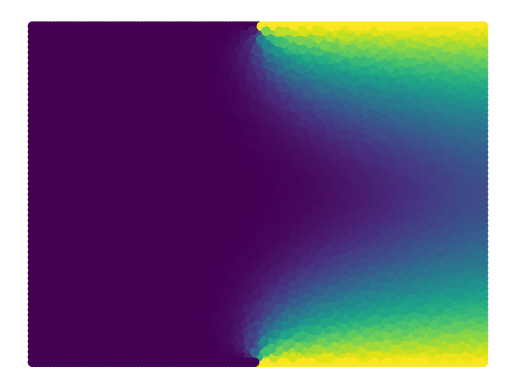

2248


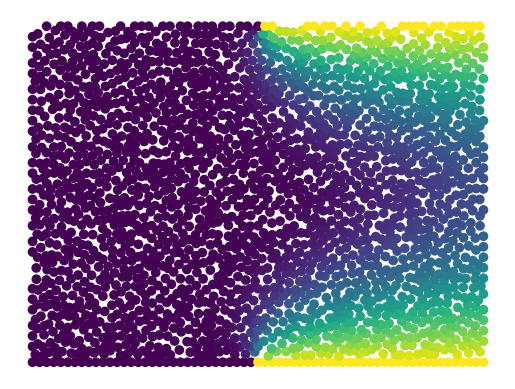

754


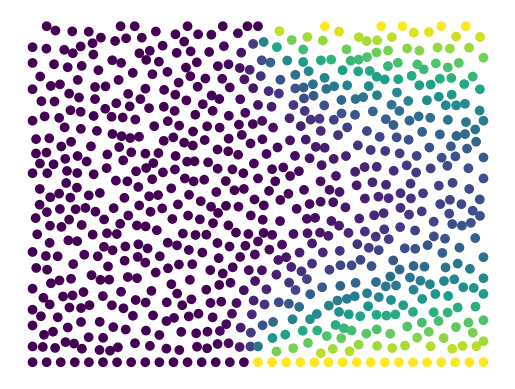

265


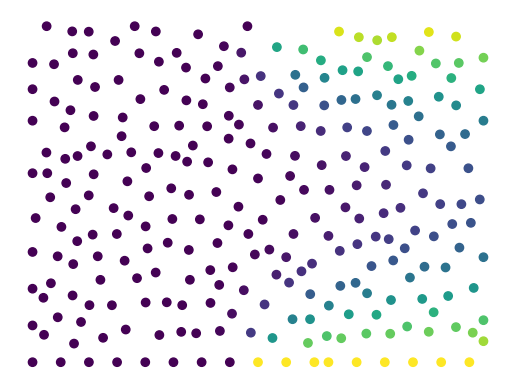

In [19]:
plt.scatter(reference_mesh[:, 0], reference_mesh[:, 1], c=snapshot_matrix[0, :])
plt.axis('off')
plt.show()

subsampled_mesh, subsampled_solution = subsample_and_plot(reference_mesh, snapshot_matrix, 'medium')
subsampled_mesh, subsampled_solution = subsample_and_plot(subsampled_mesh, subsampled_solution, 'small')
subsampled_mesh, subsampled_solution = subsample_and_plot(subsampled_mesh, subsampled_solution, 'tiny')